**План действий**
1. Применить маску к фотографиям \(убрать море, чтобы сеть быстрее обучалась\)
2. Использовать полноразмерные изображения \(выше точность\(?\)
3. SIFT / ROOTSIFT для извлечения точек
4. FAISS для сопоставления точек
5. Применить метод Keypoint Matching

![image](researchings/img.png 'Title')

Импорт библиотек

In [16]:
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
from keras import layers
from pathlib import Path
import numpy as np
import cv2

tf.debugging.set_log_device_placement(True)

print('Библиотеки успешно загружены')

Библиотеки успешно загружены


Загрузить дата-сет

In [9]:
# dataset = keras.utils.image_dataset_from_directory('Whale ReId 2_mm', labels='inferred', shuffle='False', batch_size=64, interpolation='mitchellcubic',color_mode='rgb')
# masks = keras.utils.image_dataset_from_directory('Whale ReId 2_mm masked', labels='inferred', shuffle='False', batch_size=64, color_mode='grayscale')
image_size = (256, 256)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory('Whale ReId 2_mm', labels='inferred', validation_split=0.2, subset='both', seed=1337, batch_size=batch_size, interpolation='mitchellcubic', color_mode='rgb', image_size=image_size)

Found 33644 files belonging to 102 classes.
Using 26916 files for training.
Using 6728 files for validation.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/rep

Вывод

In [38]:
from keras import layers
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip('horizontal'),
#         layers.RandomRotation(0.1),
#     ]
# )

In [10]:
def show_img(ds):
    plt.figure(figsize=(10, 10))
    for images, _ in ds.take(1):
        for i in range(9):
            # augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[0].numpy().astype('uint8'))
            plt.axis('off')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice 

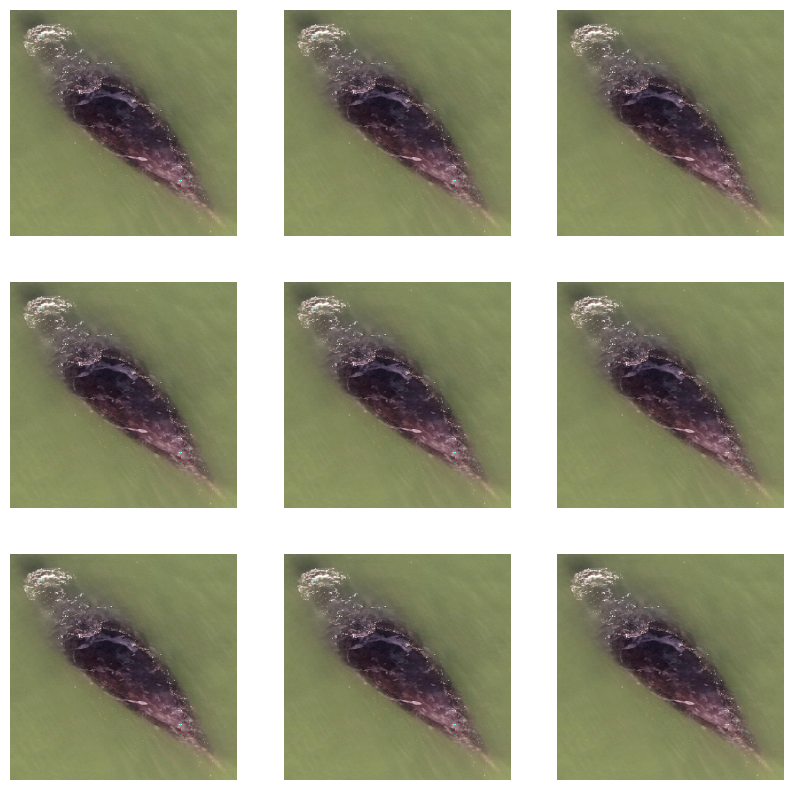

In [11]:
show_img(train_ds)

In [12]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2



In [13]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [18]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    #x = data_augmentation(inputs)
    # Входной блок
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x

    for size in [256, 512, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)


        residual = layers.Conv2D(1024, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.GlobalAveragePooling2D()(x)

        activation = 'softmax'

        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(102, activation=activation)(x)
        return keras.Model(inputs, outputs)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in

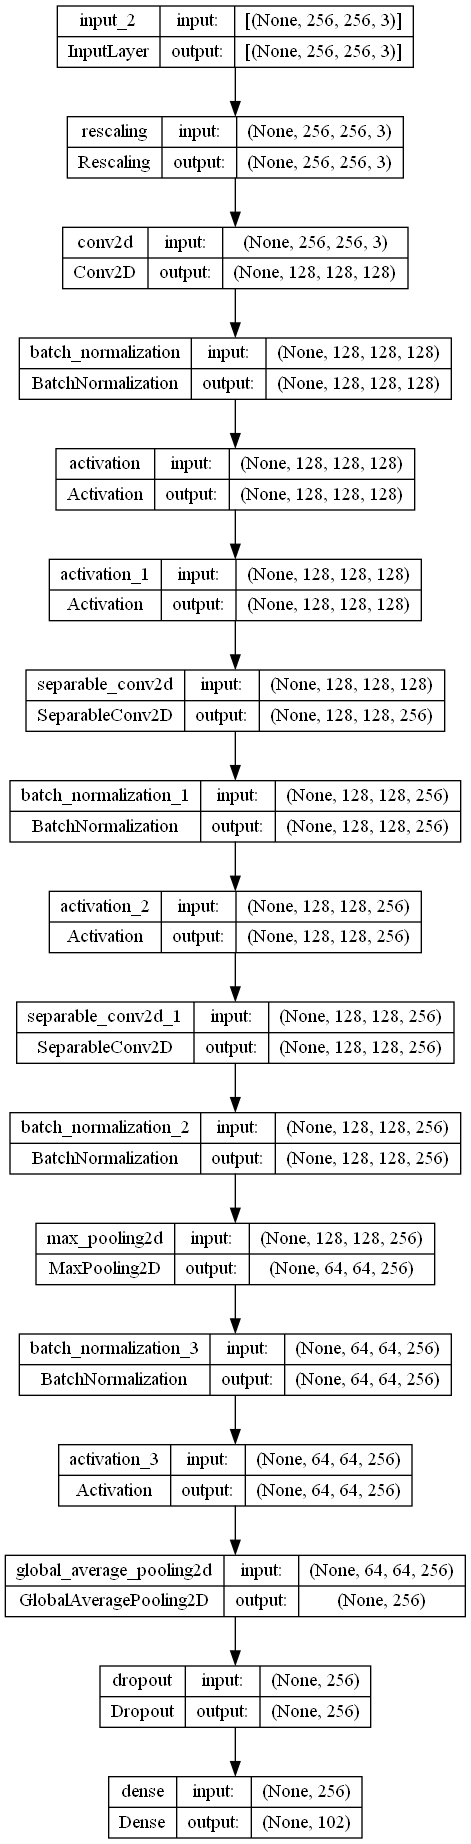

In [19]:
model = make_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras'),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['accuracy'],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in devi

In [1]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
